## RNN

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
# 下载mnist数据集
trainsets=datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()) # 格式转换

testsets=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

In [3]:
class_names=trainsets.classes # 查看类别/标签
print(class_names)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [4]:
# 查看数据集的shape
print(trainsets.data.shape)

torch.Size([60000, 28, 28])


In [5]:
print(trainsets.targets.shape)

torch.Size([60000])


In [6]:
print(testsets.data.shape)

torch.Size([10000, 28, 28])


In [7]:
print(testsets.targets.shape)

torch.Size([10000])


In [8]:
# 定义超参数
BATCH_SIZE=64 # 每批读取的数据大小
EPOCHS=20 # 训练20轮

In [9]:
# 创建数据集的可迭代对象，也就是说一个batch一个batch的读取数据
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [10]:
# 查看一批batch的数据
images,labels=next(iter(test_loader))

In [11]:
print(images.shape)

torch.Size([64, 1, 28, 28])


In [12]:
print(labels.shape)

torch.Size([64])


In [13]:
# 定义函数：显示一批数据
def imshow(inp,title=None):
    inp=inp.numpy().transpose((1,2,0))
    # mean=np.array([0.485, 0.456, 0.406]) # 均值
    # std=np.array([0.229, 0.224, 0.225]) # 标准差
    # inp=std*inp+mean
    inp=np.clip(inp,0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

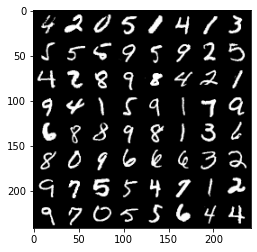

In [14]:
# 网格显示
out=torchvision.utils.make_grid(images)

imshow(out)

In [15]:
# 定义RNN模型
class RNN_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(RNN_Model, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, nonlinearity='relu')
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        # （layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，避免梯度爆炸
        out, hn = self.rnn(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

In [16]:
# 初始化模型
input_dim=28 # 输入维度
hidden_dim=300 # 隐藏的维度
layer_dim=2 # 2层RNN
output_dim=10 # 输出维度

# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = RNN_Model(input_dim, hidden_dim, layer_dim, output_dim)
model.to(device)

RNN_Model(
  (rnn): RNN(28, 300, num_layers=2, batch_first=True)
  (fc): Linear(in_features=300, out_features=10, bias=True)
)

In [17]:
# 定义损失函数
criterion=nn.CrossEntropyLoss()

In [18]:
# 定义优化器
learning_rate=0.01

optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

In [19]:
# 输出模型参数信息
length=len(list(model.parameters()))

In [20]:
# 循环打印模型参数
for i in range(length):
    print('参数：{}'.format(i))
    print(list(model.parameters())[i].size())

参数：0
torch.Size([300, 28])
参数：1
torch.Size([300, 300])
参数：2
torch.Size([300])
参数：3
torch.Size([300])
参数：4
torch.Size([300, 300])
参数：5
torch.Size([300, 300])
参数：6
torch.Size([300])
参数：7
torch.Size([300])
参数：8
torch.Size([10, 300])
参数：9
torch.Size([10])


In [21]:
# 训练模型
sequence_dim=28 # 序列长度
loss_list=[] # 保存loss
accuracy_list=[] # 保存accuracy
iteration_list=[] # 保存循环次数

iter=0
for epoch in range(EPOCHS):
    for i,(images,labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        images=images.view(-1,sequence_dim,input_dim).requires_grad_().to(device)
        labels=labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        outputs=model(images)
        # 计算损失
        loss=criterion(outputs,labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter+=1
        # 模型验证
        if iter%500==0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct=0.0
            total=0.0
            # 迭代测试集，获取数据、预测
            with torch.no_grad():
                for images,labels in test_loader:
                    images=images.view(-1,sequence_dim,input_dim).to(device)
                    # 模型预测
                    outputs=model(images)
                    # 获取预测概率最大的下标
                    predict=torch.max(outputs.data,1)[1]
                    # 统计测试集的大小
                    total+=labels.size(0)
                    # 统计判断/预测正确的数量
                    if torch.cuda.is_available():
                    correct+=(predict.cuda()==labels.cuda()).sum()
                    else:
                        correct+=(predict==labels).sum()
                # 计算accuracy
                accuracy=correct/total*100
                # 保存accuracy,loss,iteration
                loss_list.append(loss.data)
                accuracy_list.append(accuracy)
                iteration_list.append(iter)
                # 打印信息
                print("loop : {}, Loss : {}, Accuracy : {}%".format(iter, loss.item(), accuracy))

## LSTM

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

# 下载mnist数据集
trainsets=datasets.MNIST(root='./data',train=True,download=True,transform=transforms.ToTensor()) # 格式转换

testsets=datasets.MNIST(root='./data',train=False,transform=transforms.ToTensor())

# 定义超参数
BATCH_SIZE=32 # 每批读取的数据大小
EPOCHS=10 # 训练10轮

# 创建数据集的可迭代对象，也就是说一个batch一个batch的读取数据
train_loader = torch.utils.data.DataLoader(dataset=trainsets, batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=testsets, batch_size=BATCH_SIZE, shuffle=True)

In [2]:
class LSTM_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM_Model, self).__init__() # 初始化父类中的构造方法
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        # 构建LSTM模型
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # 全连接层
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        # 初始化隐层状态全为0
        # (layer_dim, batch_size, hidden_dim)
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 初始化cell state
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_().to(device)
        # 分离隐藏状态，以免梯度爆炸
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        # 只需要最后一层隐层的状态
        out = self.fc(out[:, -1, :])
        return out

In [3]:
# 2. 初始化模型
input_dim = 28 # 输入维度，图片是28X28
hidden_dim = 100 # 隐层维度100
layer_dim =1 # 1个隐层
output_dim = 10 # 输出维度：10， 即0-9共十个数字

model = LSTM_Model(input_dim, hidden_dim, layer_dim, output_dim)

# 判断是否有GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model.to(device)

LSTM_Model(
  (lstm): LSTM(28, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)

In [4]:
# 3. 循环查看
for i in range(len(list(model.parameters()))):
    print("参数：%d" %(i+1))
    print(list(model.parameters())[i].size())

参数：1
torch.Size([400, 28])
参数：2
torch.Size([400, 100])
参数：3
torch.Size([400])
参数：4
torch.Size([400])
参数：5
torch.Size([10, 100])
参数：6
torch.Size([10])


In [5]:
# 4. 初始化损失函数
criterion = nn.CrossEntropyLoss()

# 5. 初始化优化器
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
# 6. 模型训练

sequence_dim = 28 # 序列长度
loss_list = [] #  保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 循环次数
iter = 0 
for epoch in range(EPOCHS):
    for i, (images, labels) in enumerate(train_loader):
        model.train() # 声明模型训练
        # 一个batch的数据转换为RNN的输入维度
        images = images.view(-1, sequence_dim, input_dim).requires_grad_().to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累积）
        optimizer.zero_grad()
        # 前向传播
        outputs = model(images)
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计算器自增
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval()
            # 计算accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集
            with torch.no_grad():
                for images, labels in test_loader:
                    # 一个batch的数据转换为RNN的输入维度
                    images = images.view(-1, sequence_dim, input_dim).to(device)
                    # 模型预测
                    outputs = model(images)
                    # 获取预测概率最大值的下标
                    predict = torch.max(outputs.data, 1)[1]
                    # 统计label的数量
                    total += labels.size(0) # labels.size(0) = 32 ，即一个batchsize的大小
                    # 统计预测正确的数量
                    if torch.cuda.is_available():
                        correct += (predict.cuda() == labels.cuda()).sum()
                    else:
                        correct += (predict == labels).sum()
                # 计算accuracy
                accuracy = correct / total * 100
                # 保存loss,accuracy,iteration
                loss_list.append(loss.data)
                accuracy_list.append(accuracy)
                iteration_list.append(iter)
                # 打印信息
                print('loop : {} Loss : {} Accuracy : {}%'.format(iter, loss.item(), accuracy))

loop : 500 Loss : 0.2802141606807709 Accuracy : 91.63999938964844
loop : 1000 Loss : 0.12506547570228577 Accuracy : 95.5
loop : 1500 Loss : 0.048064377158880234 Accuracy : 95.9800033569336
loop : 2000 Loss : 0.16142058372497559 Accuracy : 96.11000061035156
loop : 2500 Loss : 0.025540120899677277 Accuracy : 96.36000061035156
loop : 3000 Loss : 0.3170975148677826 Accuracy : 97.39999389648438
loop : 3500 Loss : 0.09318727254867554 Accuracy : 96.19999694824219
loop : 4000 Loss : 0.1303466558456421 Accuracy : 97.44999694824219


KeyboardInterrupt: 

In [ ]:
# 可视化loss
plt.plot(iteration_list, loss_list)
plt.xlabel('Number of Iteration')
plt.ylabel('Loss')
plt.title('LSTM')
plt.show()

In [ ]:
# 可视化accuracy
plt.plot(iteration_list, accuracy_list, color='b')
plt.xlabel('Number of Iteration')
plt.ylabel('Accuracy')
plt.title('LSTM')
plt.savefig('LSTM_accuracy.png')
plt.show()